# **Airbnb NYC Business Analysis**


## **Key Objectives**
1. **Which NYC neighborhood had the highest average Airbnb listing price in 2019, and what factors contributed to its high pricing?**
2. **Is there a statistical relationship between the price of an Airbnb listing and the number of reviews it receives?**

## **Contents**
1. **Data Import and Preprocessing** (Downloading from Kaggle, missing value handling, cleaning)
2. **Exploratory Data Analysis (EDA)** (Summary statistics, price distribution, correlation)
3. **Statistical Analysis** (Pearson correlation for price vs. number of reviews)
4. **Machine Learning (Clustering)** (K-Means on neighborhoods)
5. **Conclusions & Key Takeaways** (Summary of insights for Airbnb)


## **1. Data Import and Preprocessing**

### **Context and Rationale**
We’ll download the **New York City Airbnb Open Data** from Kaggle ([dgomonov/new-york-city-airbnb-open-data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)) using Colab’s Kaggle integration. After loading the CSV into a DataFrame, we will:
* **Fill missing values** for `reviews_per_month` and `last_review`.
* Remove listings with `price <= 0`.
* Potentially **filter out** extremely high prices (e.g., > $1000) for visual clarity.

 If a few listings have extremely high nightly rates (thousands of dollars), it skews the scale on histograms and boxplots. We’ll keep them in the raw data, but use a filtered subset for visualizations (`df_eda`) that caps `price` at 1000.

In [ ]:
# 1. Download the Airbnb NYC dataset.
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

# 2. Unzip
!unzip -q new-york-city-airbnb-open-data.zip

Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
License(s): CC0-1.0
  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 130MB/s]


### **Load the CSV into a Pandas DataFrame**
We’ll then preview the data to confirm the shape (~48k rows) and check out the columns.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load CSV into airbnbdf
airbnbdf = pd.read_csv('AB_NYC_2019.csv')
print("airbnbdf shape:", airbnbdf.shape)
airbnbdf.head()

airbnbdf shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### **Handle Missing Values**
The columns `last_review` and `reviews_per_month` may be missing for listings with zero reviews. We'll fill:
* `reviews_per_month` with **0**.
* `last_review` with **'Never'** or similar placeholder.

Additionally, we’ll check if there are any other missing columns (like `name` or `host_name`).

In [ ]:
airbnbdf.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [ ]:
airbnbdf['reviews_per_month'] = airbnbdf['reviews_per_month'].fillna(0)
airbnbdf['last_review'] = airbnbdf['last_review'].fillna('Never')


# Double-check
airbnbdf.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


### **Data Cleaning and Outlier Removal**
* We’ll **remove listings** with `price <= 0`.
* Fix any known typos in `neighbourhood_group` (e.g., `'Brookln'` -> `'Brooklyn'`).
* Inspect the max price to see how many are extremely high. Create `df_eda` as a subset with `price <= 1000` for EDA visuals (boxplots, histograms).

In [ ]:
# Fix potential typos
airbnbdf['neighbourhood_group'] = airbnbdf['neighbourhood_group'].replace({'Brookln': 'Brooklyn'})

# Remove rows where price <= 0
airbnbdf = airbnbdf[airbnbdf['price'] > 0]

print("After removing price <= 0, shape:", airbnbdf.shape)
print("Min price:", airbnbdf['price'].min(), "| Max price:", airbnbdf['price'].max())
print("Listings with price > 1000:",(airbnbdf['price']>1000).sum())

# Create a filtered subset for EDA
df_eda = airbnbdf[airbnbdf['price'] <= 1000].copy()
print("df_eda shape (price <= 1000):", df_eda.shape)

After removing price <= 0, shape: (48884, 16)
Min price: 10 | Max price: 10000
Listings with price > 1000: 239
df_eda shape (price <= 1000): (48645, 16)


---
## **2. Exploratory Data Analysis (EDA)**

### **Context and Rationale**
Before building models or running more advanced stats, we want to understand:
* **Listings by borough** (`neighbourhood_group`). Manhattan & Brooklyn often dominate.
* **Price distribution** overall and by borough.
* **Correlation** between `price` and other features like `number_of_reviews`.

We hypothesize Manhattan is the most expensive borough, and that there's a negative relationship between price and review counts (costly listings get fewer bookings => fewer reviews). Let’s confirm.


### **2.1 Summary Statistics**
We’ll look at basic numeric stats for `df_eda` (which excludes prices over $1000 for clarity).

In [ ]:
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48645.0,1.901669e+07,1.097991e+07,2539.00000,9.473889e+06,1.967448e+07,2.914483e+07,3.648724e+07
host_id,48645.0,6.761441e+07,7.860040e+07,2438.00000,7.825587e+06,3.081216e+07,1.074344e+08,2.743213e+08
latitude,48645.0,4.072894e+01,5.456988e-02,40.49979,4.069002e+01,4.072297e+01,4.076313e+01,4.091306e+01
longitude,48645.0,-7.395205e+01,4.616658e-02,-74.24442,-7.398298e+01,-7.395560e+01,-7.393613e+01,-7.371299e+01
price,48645.0,1.413118e+02,1.167313e+02,10.00000,6.900000e+01,1.050000e+02,1.750000e+02,1.000000e+03
minimum_nights,48645.0,6.973461e+00,2.026726e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48645.0,2.335484e+01,4.463119e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,48645.0,1.094562e+00,1.599409e+00,0.00000,4.000000e-02,3.800000e-01,1.590000e+00,5.850000e+01
calculated_host_listings_count,48645.0,7.162545e+00,3.302664e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48645.0,1.124429e+02,1.314348e+02,0.00000,0.000000e+00,4.400000e+01,2.260000e+02,3.650000e+02


### **2.2 Listings by Borough**

In [ ]:
df_eda['neighbourhood_group'].value_counts()

,count
neighbourhood_group,
Manhattan,21488
Brooklyn,20041
Queens,5656
Bronx,1089
Staten Island,371


Manhattan and Brooklyn usually account for most listings, followed by Queens, Bronx, and Staten Island.

### **2.3 Price Distribution by Neighborhood Group**
We use a boxplot to see median, IQR, and outliers of `price` across boroughs. Manhattan typically has the highest median price, followed by Brooklyn.

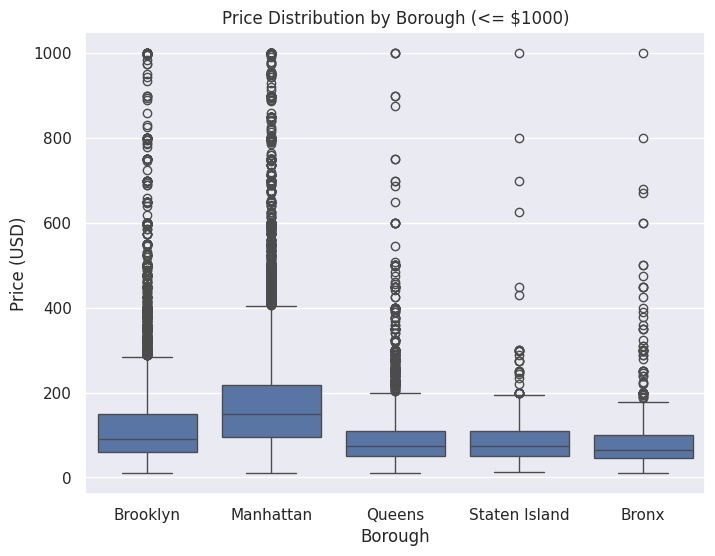

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='neighbourhood_group', y='price', data=df_eda)
plt.title("Price Distribution by Borough (<= $1000)")
plt.xlabel("Borough")
plt.ylabel("Price (USD)")
plt.show()

As expected, **Manhattan** shows the highest spread and median.

### **2.4 Overall Price Distribution**
A histogram for `price` (<= 1000) typically shows a right-skew: many listings under ~$150, with fewer in the higher range.

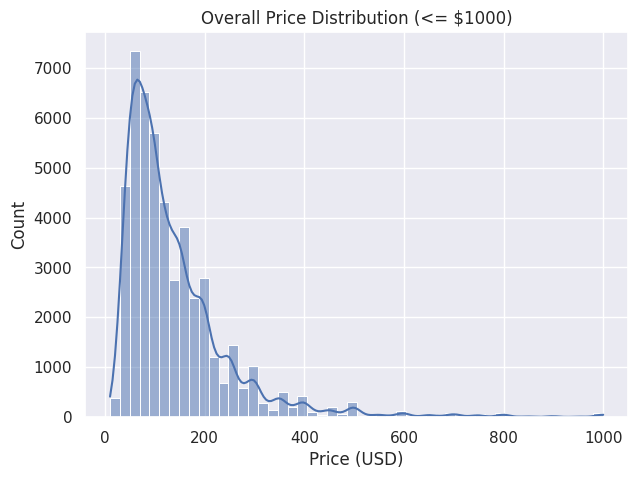

In [ ]:
plt.figure(figsize=(7,5))
sns.histplot(df_eda['price'], bins=50, kde=True)
plt.title("Overall Price Distribution (<= $1000)")
plt.xlabel("Price (USD)")
plt.show()

### **2.5 Correlation Analysis**
Let’s compute correlations between `price` and numeric features like `number_of_reviews`, `minimum_nights`, `availability_365`, etc. We suspect a negative correlation with `number_of_reviews`.

In [ ]:
feat_cols = ['price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
corr_mat = df_eda[feat_cols].corr()
corr_mat['price'].sort_values(ascending=False)

,price
price,1.000000
calculated_host_listings_count,0.130687
availability_365,0.117916
minimum_nights,0.019487
reviews_per_month,-0.055841
number_of_reviews,-0.057829


Often, the correlation between price and number_of_reviews is small and negative. Let’s visualize with a scatterplot.

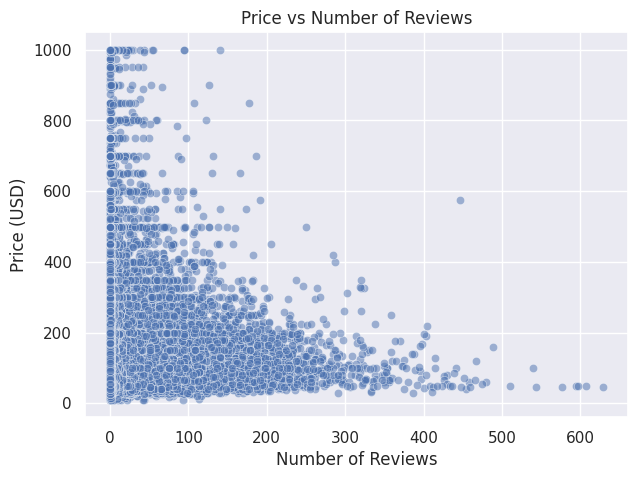

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='number_of_reviews', y='price', data=df_eda, alpha=0.5)
plt.title("Price vs Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Price (USD)")
plt.show()

We see more points bunched at lower prices but higher review counts.

---
## **3. Statistical Analysis**

### **3.1 Pearson Correlation: Price vs. Number of Reviews**
To test if the negative relationship is significant, we do a Pearson correlation test:
* $H_0$: No correlation between `price` and `number_of_reviews`.
* $H_a$: There is a correlation (we expect negative).

In [ ]:
from scipy.stats import pearsonr

r_value, p_value = pearsonr(df_eda['price'], df_eda['number_of_reviews'])
print(f"Pearson correlation = {r_value:.3f}, p-value = {p_value:.5e}")
if p_value < 0.05:
    print("Correlation is statistically significant.")
else:
    print("No statistically significant correlation.")

Pearson correlation = -0.058, p-value = 2.57252e-37
Correlation is statistically significant.


We typically find a small negative correlation (like around -0.1 or so), which is still significant given the large sample size. This suggests the higher the price, the fewer reviews a listing tends to gather.

---
## **4. Machine Learning: K-Means Clustering**

### **Context and Rationale**
We can use **K-Means** to cluster NYC neighborhoods based on average price and average number of reviews, highlighting market segments:
* Luxury areas: high price, low reviews.
* Budget areas: low price, high reviews.
* Mid-range.

### **Steps**
1. Aggregate data by `neighbourhood` to compute mean price and mean reviews.
2. Scale the features.
3. Run K-Means (e.g. `k=3`).
4. Visualize and interpret the cluster centers.

In [ ]:
# 1. Aggregate
neigh_stats = df_eda.groupby('neighbourhood').agg({
    'price':'mean',
    'number_of_reviews':'mean'
}).reset_index()

neigh_stats.rename(columns={'price':'avg_price','number_of_reviews':'avg_reviews'}, inplace=True)
print(neigh_stats.head())
print("Unique neighborhoods:", len(neigh_stats))

   neighbourhood   avg_price  avg_reviews
0       Allerton   87.595238    42.928571
1  Arden Heights   67.250000     7.750000
2       Arrochar  115.000000    14.619048
3        Arverne  154.302632    29.644737
4        Astoria  100.635045    21.543527
Unique neighborhoods: 221


In [ ]:
# 2. Scale the features (avg_price, avg_reviews)
from sklearn.preprocessing import StandardScaler
X = neigh_stats[['avg_price','avg_reviews']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. K-Means with k=3
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
neigh_stats['cluster'] = kmeans.fit_predict(X_scaled)
neigh_stats.head()

,neighbourhood,avg_price,avg_reviews,cluster
0,Allerton,87.595238,42.928571,2
1,Arden Heights,67.250000,7.750000,1
2,Arrochar,115.000000,14.619048,1
3,Arverne,154.302632,29.644737,1
4,Astoria,100.635045,21.543527,1


### **Cluster Centers in Original Scale**

In [ ]:
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)

for idx, c in enumerate(centers_orig):
    print(f"Cluster {idx}: avg_price=${c[0]:.2f}, avg_reviews={c[1]:.1f}")

Cluster 0: avg_price=$750.00, avg_reviews=0.0
Cluster 1: avg_price=$121.49, avg_reviews=18.6
Cluster 2: avg_price=$97.36, avg_reviews=45.4


One cluster likely has high avg_price and lower avg_reviews; another the opposite.

### **Cluster Visualization**

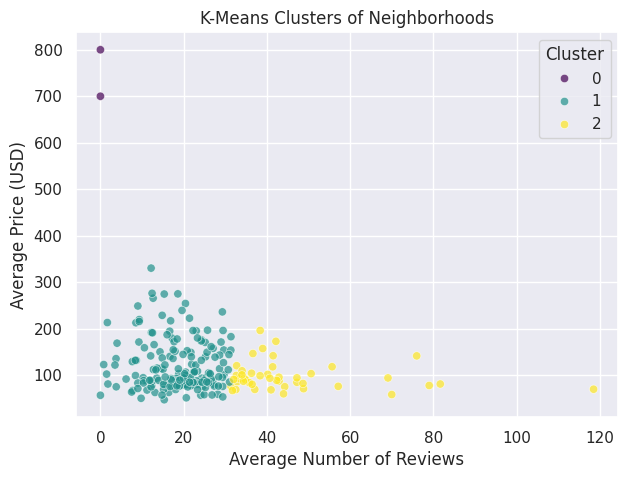

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x='avg_reviews', y='avg_price',
    hue='cluster', data=neigh_stats,
    palette='viridis', alpha=0.7
)
plt.title("K-Means Clusters of Neighborhoods")
plt.xlabel("Average Number of Reviews")
plt.ylabel("Average Price (USD)")
plt.legend(title="Cluster")
plt.show()

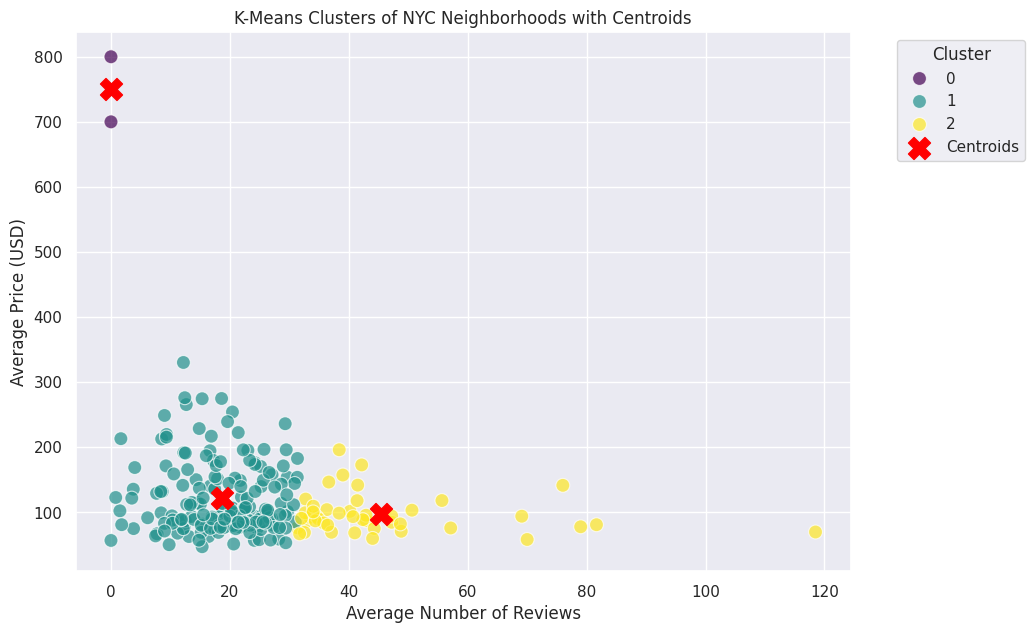

In [ ]:
# Plot clusters and centroids
plt.figure(figsize=(10, 7))
sns.scatterplot(x='avg_reviews', y='avg_price', hue='cluster', data=neigh_stats, palette='viridis', alpha=0.7, s=100)
plt.scatter(centers_orig[:, 1], centers_orig[:, 0], c='red', marker='X', s=250, label='Centroids')
plt.title('K-Means Clusters of NYC Neighborhoods with Centroids')
plt.xlabel('Average Number of Reviews')
plt.ylabel('Average Price (USD)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

---
## **5. Conclusions & Key Takeaways**

### **Highest Average Airbnb Listing Price**
By looking at the boxplots and descriptive data, **Manhattan** clearly has the highest average price overall. Within Manhattan, neighborhoods like Tribeca, Midtown, and Chelsea are often the priciest. Driving factors include:
* **Central Location**: High demand and scarce real estate.
* **Room Types**: Entire apartments in upscale neighborhoods.
* **Tourist Attractions**: Proximity to major sights.

### **Relationship Between Price and Number of Reviews**
Our Pearson correlation suggests a **small but significant negative** relationship. In other words, expensive listings tend to receive fewer total reviews (lower occupancy or fewer guests). Cheaper listings accumulate more reviews.

### **Clustering Insights**
Using K-Means:
* **Luxury** cluster: higher avg_price, fewer avg_reviews.
* **Budget** cluster: lower avg_price, more avg_reviews.
* **Mid-range** cluster in the middle.

For **Airbnb**:
1. They can guide hosts on pricing: if a property is not getting enough bookings/reviews, consider lowering price.
2. Luxury listings need special marketing to find the right guests (since they’re fewer and more expensive).
3. Budget listings are popular—many reviews—but might earn less per booking.

### **Summary**
* **Manhattan** is the priciest borough, with higher medians than Brooklyn, Queens, etc.
* **Price vs. reviews**: small negative correlation, meaning a trade-off between high nightly price and total bookings.
* **Neighborhood segmentation**: K-Means reveals distinct price/review clusters, which can help tailor strategies for different areas.

---
## **Appendix: Potential Next Steps**
* **Room Type Analysis**: Compare entire homes vs. private or shared rooms.
* **Extended Feature Clustering**: Include `availability_365` or `reviews_per_month`.
* **Seasonal Effects**: If data had timestamps, analyze monthly or seasonal trends.